In [1]:
import os
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandana as pdna
import pandas as pd

from nad.load import (
    get_census_level,
    load_ageb_geometry,
    load_all_equipments,
    load_block_geometry,
    load_census,
)

In [2]:
data_path = Path(os.environ["DATA_PATH"])
geostatistical_framework_path = Path(os.environ["GEOSTATISTICAL_FRAMEWORK_PATH"])
population_grids_path = Path(os.environ["POPULATION_GRIDS_PATH"])
census_path = Path(os.environ["CENSUS_PATH"])

cache_path = Path("./cache")
results_path = Path("./results")

# Constants

In [3]:
ADJUSTMENT_FACTOR = 3
WALK_SPEED = 5  # km/h
MAX_DISTANCE = 10_000  # aprox 2 hour of walking
NUM_POIS = 5

EQUIPAMIENTOS = {
    "guarderia": {"radius": 750},
    "preescolar": {"radius": 750},
    "primaria": {"radius": 500},
    "secundaria": {"radius": 1_000},
    "preparatoria": {"radius": 5_000},
    "universidad": {"radius": 50_000},
    "parque": {"radius": 670},
    "auditorio": {"radius": 1_000},
    "biblioteca": {"radius": 10_000},
    "cine": {"radius": 1_500},
    "unidad_deportiva": {"radius": 10_000},
    "hospital": {"radius": 50_000},
    "centro_salud": {"radius": 1_000},
}

# Functions

In [4]:
def create_network(
    gdf_vialidades: gpd.GeoDataFrame,
    net_path: os.PathLike,
    max_distance: float,
) -> pdna.Network:
    gdf_edges = gdf_vialidades.explode(index_parts=False)

    gdf_edges["u_geom"] = gdf_edges.geometry.apply(lambda geom: geom.coords[0])
    gdf_edges["v_geom"] = gdf_edges.geometry.apply(lambda geom: geom.coords[-1])

    gdf_nodes = pd.DataFrame(
        pd.concat([gdf_edges["u_geom"], gdf_edges["v_geom"]])
        .drop_duplicates()
        .tolist(),
        columns=["x", "y"],
    ).reset_index(drop=True)
    gdf_nodes["node_id"] = gdf_nodes.index

    coord_to_id = {
        (row.x, row.y): row.node_id for row in gdf_nodes.itertuples(index=False)
    }
    gdf_edges["u"] = gdf_edges["u_geom"].map(coord_to_id)
    gdf_edges["v"] = gdf_edges["v_geom"].map(coord_to_id)

    gdf_edges["distance"] = gdf_edges.geometry.length
    gdf_edges = gdf_edges[["u", "v", "distance"]].reset_index(drop=True)
    gdf_nodes = gdf_nodes[["node_id", "x", "y"]]

    net = pdna.Network(
        gdf_nodes["x"],
        gdf_nodes["y"],
        gdf_edges["u"],
        gdf_edges["v"],
        gdf_edges[["distance"]],
    )
    net.precompute(max_distance)
    net.save_hdf5(net_path)
    return net


def get_proximities(
    net: pdna.Network,
    coords: pd.DataFrame,
    poi_type: str,
    max_distance: float,
    num_pois: int = 1,
) -> pd.Series:
    net.set_pois(poi_type, max_distance, num_pois, coords["x"], coords["y"])
    res = (
        net.nearest_pois(
            distance=max_distance,
            category=poi_type,
            num_pois=num_pois,
            include_poi_ids=True,
        )
        .rename(columns={x: f"distance{x}" for x in range(1, num_pois + 1)})
        .reset_index(names="origin_id")
    )
    return pd.wide_to_long(
        res,
        stubnames=["distance", "poi"],
        i="origin_id",
        j="num_poi",
        sep="",
    ).rename(columns={"poi": "destination_id"})


def get_accessibility_metrics(
    net: pdna.Network,
    destinations: gpd.GeoDataFrame,
    weights: pd.Series,
    amenity: str,
    max_distance: float,
    num_pois: int,
    walk_speed: float,
    radius: float,
    adjustment_factor: float,
):
    proximities = get_proximities(
        net,
        destinations.get_coordinates(),
        amenity,
        max_distance=max_distance,
        num_pois=num_pois,
    )
    proximities["time"] = (proximities["distance"] / 1000) * 60 / walk_speed
    proximities = proximities.join(weights, on="origin_id")
    proximities = proximities.join(destinations[["capacity"]], on="destination_id")
    proximities["gravity"] = 1 / np.exp(
        1 / (radius / adjustment_factor) * proximities["distance"],
    )
    proximities["reach"] = proximities["gravity"] * proximities[weights.name]
    destinations = (
        proximities.groupby("destination_id")
        .agg({"reach": "sum", "capacity": "first"})
        .assign(
            opportunities_ratio=lambda df: df.apply(
                lambda x: x["capacity"] / x["reach"] if x["reach"] > 0 else 0,
                axis=1,
            ),
        )
        .query("opportunities_ratio > 0")
    )
    proximities["accessibility_score"] = proximities.apply(
        lambda x: destinations["opportunities_ratio"].loc[x["destination_id"]]
        * x["gravity"]
        if x["destination_id"] in destinations["opportunities_ratio"].index
        else 0,
        axis=1,
    )
    return (
        proximities.reset_index()
        .groupby("origin_id")
        .agg({"accessibility_score": "sum", "time": "min"})
    )

# Datos

## Equipamientos

In [5]:
df_equip = load_all_equipments(data_path).assign(capacity=1, geometry=lambda df: df["geometry"].centroid)

## AGEBs

In [6]:
df_geom_agebs = load_ageb_geometry(
    population_grids_path / "final" / "zone_agebs" / "shaped" / "2020" / "08.2.03.gpkg",
)

## Manzanas

In [7]:
df_census_base = load_census(census_path / "2020" / "08.csv")
df_census_blocks = get_census_level(df_census_base, level="block")

df_geom_blocks = load_block_geometry(
    geostatistical_framework_path / "2020" / "08_chihuahua" / "08m.shp",
    ageb_cvegeos=df_geom_agebs.index,
)

df_blocks = df_geom_blocks.join(df_census_blocks, how="inner").filter(
    ["POBTOT", "TVIVPARHAB", "CVEGEO_AGEB", "geometry"],
)

# Stats

In [8]:
net_path = cache_path / f"network_{hash(MAX_DISTANCE)}.h5"

if not net_path.exists():
    gdf_vialidades = gpd.read_file(
        data_path / "datos/Vialidad/VialidadWgs84.shp",
    ).to_crs(
        "EPSG:6372",
    )
    net = create_network(gdf_vialidades, net_path, MAX_DISTANCE)
else:
    net = pdna.Network.from_hdf5(net_path)

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 59222
Setting CH edge vector of size 82175
Range graph removed 174 edges of 164350
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [9]:
coords = df_blocks.centroid.get_coordinates()
df_blocks_accessibility = (
    df_blocks.assign(origin_id=net.get_node_ids(coords["x"], coords["y"]))
    .reset_index()
    .set_index("origin_id")
)

In [10]:
scores = pd.DataFrame()
for nombre, item in EQUIPAMIENTOS.items():
    df_temp = df_equip[df_equip["equipamiento"] == nombre].assign(capacity=1)
    accessibility_scores = get_accessibility_metrics(
        net,
        df_temp,
        df_blocks_accessibility["POBTOT"],
        nombre,
        MAX_DISTANCE,
        NUM_POIS,
        WALK_SPEED,
        item["radius"],
        ADJUSTMENT_FACTOR,
    )
    accessibility_scores["category"] = nombre
    scores = pd.concat([scores, accessibility_scores])

In [11]:
final_score = scores.groupby("origin_id").agg({"accessibility_score": "sum"})
results = df_blocks_accessibility.join(final_score)

df_blocks_accessibility = df_blocks_accessibility.assign(
    accessibility_score=results["accessibility_score"],
)

Q3 = df_blocks_accessibility["accessibility_score"].quantile(0.9)
upper_bound = Q3 + 1.5 * Q3

df_blocks_accessibility["accessibility_score"] = df_blocks_accessibility["accessibility_score"].clip(
    0,
    upper_bound,
)
df_blocks_accessibility["accessibility_score"] = (
    df_blocks_accessibility["accessibility_score"] - df_blocks_accessibility["accessibility_score"].min()
) / (df_blocks_accessibility["accessibility_score"].max() - df_blocks_accessibility["accessibility_score"].min())

df_blocks_accessibility = df_blocks_accessibility.reset_index().set_index("CVEGEO")

In [12]:
temp = df_blocks_accessibility.join(scores[["time", "category"]], on="origin_id")

parque = temp.query("category == 'parque'")

manzanas_clinica_hospital = (
    temp[temp["category"].isin(["centro_salud", "hospital"])]
    .groupby("CVEGEO")
    .agg({"time": "min", "TVIVPARHAB": "first"})
)

preparatoria = temp.query("category == 'preparatoria'")

df_blocks_accessibility = df_blocks_accessibility.assign(
    tiempo_parque=parque["time"],
    tiempo_clinica_hospital=manzanas_clinica_hospital["time"],
    tiempo_preparatoria=preparatoria["time"],
    hogares_parque_15mi=parque[parque["time"] <= 15]["TVIVPARHAB"].fillna(0),
    hogares_clinica_hospital_30mi=manzanas_clinica_hospital[
        manzanas_clinica_hospital["time"] <= 30
    ]["TVIVPARHAB"].fillna(0),
    hogares_preparatoria_30mi=preparatoria[preparatoria["time"] <= 30][
        "TVIVPARHAB"
    ].fillna(0),
)

df_blocks_accessibility.to_file(results_path / "accessibility_blocks.gpkg")

array([[<Axes: title={'center': 'accessibility_score'}>]], dtype=object)

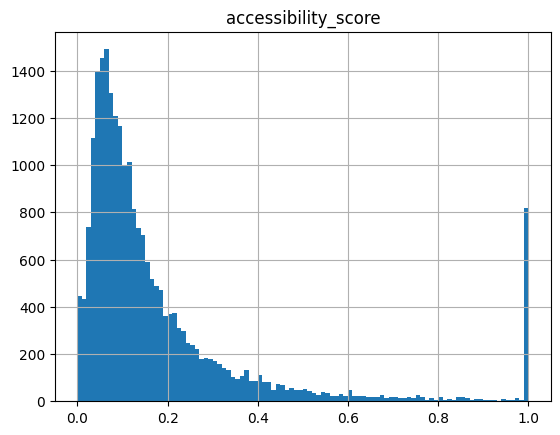

In [13]:
df_blocks_accessibility.hist(column="accessibility_score", bins=100, range=(0, 1))

<Axes: >

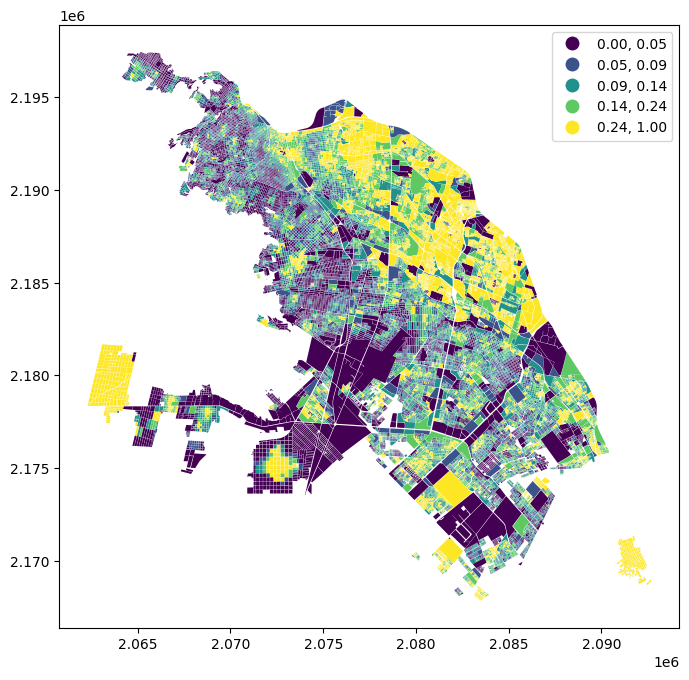

In [14]:
df_blocks_accessibility.plot(
    column="accessibility_score",
    scheme="quantiles",
    k=5,
    legend=True,
    figsize=(8, 8),
)